# Import Modules

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O Tiny_Shakespeare.txt

--2025-04-06 20:10:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘Tiny_Shakespeare.txt’

Tiny_Shakespeare.tx 100%[===================>]   1.06M  4.12MB/s    in 0.3s    

2025-04-06 20:10:29 (4.12 MB/s) - ‘Tiny_Shakespeare.txt’ saved [1115394/1115394]



In [ ]:
!pip install -q torchinfo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Character Level Tokenization

In [ ]:
with open('/content/Tiny_Shakespeare.txt', 'r') as f:
  text = f.read()

In [ ]:
chars = list(set(text))
data_size, vocab_size = len(text), len(chars)
print(f'The Text has {data_size} characters, {vocab_size} unique.')
print(f'This is our vocabulary: \n{"".join(chars)}')

# Indexing
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

The Text has 1115394 characters, 65 unique.
This is our vocabulary: 
LMibS p?emv'fTD
$QxNh3RErs.!PJdHtKBu;Y-WOnqzCUgV,GXZF:kcoajl&AIwy


As you may notice the blank char is also included in our vocabulary.

In [ ]:
assert '' in "".join(chars)

In [ ]:
encoder = lambda s: [char_to_ix[c] for c in s]
decoder = lambda l: ''.join([ix_to_char[i] for i in l])

For explainability purpose, the above lines which have been written using the **lambda** function correspond to:

In [ ]:
# Encoder as Example
def Encoder(string: str):
  list_of_ints = []
  for c in string:
    list_of_ints.append(char_to_ix[c])
  return list_of_ints

The next step consist of encoding the whole Tiny Shakespeare Dataset.

In [ ]:
data = torch.tensor(encoder(text), dtype = torch.long)
print(data.shape, data.dtype)
print('Encoded Text:', data[:5].tolist())
print('Decoded Text:', decoder(data[:5].tolist()))

torch.Size([1115394]) torch.int64
Encoded Text: [52, 2, 24, 25, 32]
Decoded Text: First


Now lets' split our dataset in Train and Validation set as usual.

In [ ]:
n = int(0.9 * len(text))
train_data = data[:n]
val_data = data[n:]

Finally, before proceding further, it is worth to show how the autoregressive mechanism works during a Language Model training, in particular we have to consider a fixed context lenght and the relative target variable to predict.

In [ ]:
max_context_lenght = 10
lm_input = train_data[:max_context_lenght]
lm_target = train_data[1 :max_context_lenght + 1] # 1 is the offset to shift the targets

print(f'Input Example: {lm_input.tolist()}')
print(f'Decoded Input Example: {decoder(lm_input.tolist())}')

Input Example: [52, 2, 24, 25, 32, 5, 44, 2, 32, 2]
Decoded Input Example: First Citi


Notice that `lm_target` is just `lm_input` shifted by one position.

In [ ]:
for t in range(max_context_lenght):
  context = lm_input[:t+1].tolist()
  target = lm_target[t].tolist()

  print(f'When input is {context} the target is: {target}')

print('\n--- Decoded ---\n')

for t in range(max_context_lenght):
  context = lm_input[:t+1].tolist()
  target = [lm_target[t].tolist()]

  print(f'When input is {decoder(context)} the target is: {decoder(target)}')

When input is [52] the target is: 2
When input is [52, 2] the target is: 24
When input is [52, 2, 24] the target is: 25
When input is [52, 2, 24, 25] the target is: 32
When input is [52, 2, 24, 25, 32] the target is: 5
When input is [52, 2, 24, 25, 32, 5] the target is: 44
When input is [52, 2, 24, 25, 32, 5, 44] the target is: 2
When input is [52, 2, 24, 25, 32, 5, 44, 2] the target is: 32
When input is [52, 2, 24, 25, 32, 5, 44, 2, 32] the target is: 2
When input is [52, 2, 24, 25, 32, 5, 44, 2, 32, 2] the target is: 43

--- Decoded ---

When input is F the target is: i
When input is Fi the target is: r
When input is Fir the target is: s
When input is Firs the target is: t
When input is First the target is:  
When input is First  the target is: C
When input is First C the target is: i
When input is First Ci the target is: t
When input is First Cit the target is: i
When input is First Citi the target is: z


Finally, the last thing to do is to organize our data in batches.

In [ ]:
torch.manual_seed(42)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[25,  5, 20,  2, 25,  5, 59, 56],
        [ 5, 32, 20,  8, 24,  8,  5, 55],
        [23, 19, 44, 23, 53, 15, 13, 56],
        [25, 32, 48,  5, 63,  2, 32, 20]])
targets:
torch.Size([4, 8])
tensor([[ 5, 20,  2, 25,  5, 59, 56, 10],
        [32, 20,  8, 24,  8,  5, 55, 57],
        [19, 44, 23, 53, 15, 13, 56,  5],
        [32, 48,  5, 63,  2, 32, 20, 15]])
----
when input is [25] the target: 5
when input is [25, 5] the target: 20
when input is [25, 5, 20] the target: 2
when input is [25, 5, 20, 2] the target: 25
when input is [25, 5, 20, 2, 25] the target: 5
when input is [25, 5, 20, 2, 25, 5] the target: 59
when input is [25, 5, 20, 2, 25, 5, 59] the target: 56
when input is [25, 5, 20, 2, 25, 5, 59, 56] the target: 10
when input is [5] the target: 32
when input is [5, 32] the target: 20
when input is [5, 32, 20] the target: 8
when input is [5, 32, 20, 8] the target: 24
when input is [5, 32, 20, 8, 24] the target: 8
when input is [5, 32, 20, 8, 24, 8]

# DataSet Class

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, data, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # Input x is a block of data starting from idx
        x = self.data[idx:idx + self.block_size]

        # Target y is the data shifted by one position (next value in sequence)
        y = self.data[idx + 1:idx + self.block_size + 1]

        #  context = lm_input[:t+1].tolist()
        #target = [lm_target[t].tolist()]


        return x, y

In [ ]:
# Example dataset
train_d = torch.arange(1000)  # Example data (0, 1, 2, ..., 999)
block_size = 50               # Sequence length
batch_size = 32               # Batch size

# Initialize the custom dataset
train_ds = SequenceDataset(train_d, block_size)

# Initialize the DataLoader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Iterating over the DataLoader
print(f'Number of batches: {len(train_loader)}')

Number of batches: 30


In [ ]:
# Check the first batch
for i, (x_batch, y_batch) in enumerate(train_loader):
    if i == 0:
      print('Shape: ', (x_batch.shape, y_batch.shape))
      print("\nInputs:")
      print(x_batch)
      print("\nTargets:")
      print(y_batch)
      break

Shape:  (torch.Size([32, 50]), torch.Size([32, 50]))

Inputs:
tensor([[694, 695, 696,  ..., 741, 742, 743],
        [560, 561, 562,  ..., 607, 608, 609],
        [145, 146, 147,  ..., 192, 193, 194],
        ...,
        [341, 342, 343,  ..., 388, 389, 390],
        [555, 556, 557,  ..., 602, 603, 604],
        [148, 149, 150,  ..., 195, 196, 197]])

Targets:
tensor([[695, 696, 697,  ..., 742, 743, 744],
        [561, 562, 563,  ..., 608, 609, 610],
        [146, 147, 148,  ..., 193, 194, 195],
        ...,
        [342, 343, 344,  ..., 389, 390, 391],
        [556, 557, 558,  ..., 603, 604, 605],
        [149, 150, 151,  ..., 196, 197, 198]])


# DataSet & DataLoader

In [ ]:
block_size = 20  # Sequence length
batch_size = 64  # Batch size

# Initialize the custom dataset
train_dataset = SequenceDataset(train_data, block_size)
val_dataset = SequenceDataset(val_data, block_size)

# Initialize the DataLoader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

# Iterating over the DataLoader
print(f'Number of batches: {len(train_loader)}')

Number of batches: 15685


# Language Model LSTM based

## Architecture

In [ ]:
class LSTM_LM(nn.Module):
  def __init__(self, vocab_size, device, dropout = 0, embedding_size = 16, n_layer = 3):
    super().__init__()

    self.vocab_size = vocab_size
    self.embedding_size = embedding_size # Model dimension
    self.n_layer = n_layer
    self.dropout = dropout
    self.device = device

    self.token_embedding = nn.Embedding(vocab_size, embedding_size)

    self.lstm = nn.LSTM(input_size= embedding_size,
                        hidden_size = embedding_size,
                        num_layers =  n_layer,
                        dropout = dropout,
                        batch_first = True)

    self.linear = nn.Linear(embedding_size, vocab_size) # logits layer

  def forward(self, idx: torch.tensor, targets = None, initial_state = None):

    # Ensure idx is a tensor on the correct device and dtype
    if not isinstance(idx, torch.Tensor):
        idx = torch.tensor(idx, dtype=torch.long, device=self.device)
    else:
        idx = idx.to(dtype=torch.long, device=self.device)

    # input_shape : batch_size x seq_length ---> word_index sequence
    # logits_shape : batch_size x seq_length x embedd_dim
    x = self.token_embedding(idx)
    x, (h_n, c_n) = self.lstm(x, initial_state)

    # logits_shape : batch_size x seq_length x embedd_dim
    logits = self.linear(x)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def init_hidden(self, batch_size):
        """
        Inizialize the cell state and the hidden state.
        """
        h0 = torch.zeros(self.n_layer, batch_size, self.embedding_size).to(self.device)
        c0 = torch.zeros(self.n_layer, batch_size, self.embedding_size).to(self.device)

        return (h0, c0)

  def generate(self, idx, max_new_tokens, temperature = 1.0):
        """
        Generate text based on a seed input.
        idx: Tensor of shape (B, T) with indices (current context)
        max_new_tokens: The maximum number of tokens to generate
        temperature: Controls randomness in predictions
        """
        self.eval()  # Set model to evaluation mode

        # Initialize hidden state
        hidden = self.init_hidden(batch_size = 1)

        for _ in range(max_new_tokens):
            # Get predictions
            logits, _ = self(idx, initial_state = hidden)

            # Focus on the last time step (B, C)
            logits = logits[:, -1, :]

            # Apply softmax to get probabilities
            probs = F.softmax(logits / temperature, dim=-1)  # (B, C)

            # Sample the next token
            idx_next = torch.multinomial(probs, num_samples = 1)  # Shape (B, 1)

            # Append the sampled token to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)

        return idx

## Training

In [ ]:
def train(model, train_loader, val_loader, epochs=20, batch_size=32, learning_rate=1e-3, device='cuda'):
    """
    Train the LSTM Language Model and save the model every 10 epochs.

    Args:
    - model: The LSTM_LM model instance
    - train_loader: The DataLoader for training data
    - val_loader: The DataLoader for validation data
    - epochs: Total number of epochs for training
    - batch_size: The batch size
    - learning_rate: The learning rate for the optimizer
    - device: 'cuda' or 'cpu' for computation
    """
    model.to(device)
    model.train()  # Set the model to training mode

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Directory to save the model checkpoints
    drive.mount('/content/drive')
    save_dir = '/content/drive/My Drive/model_checkpoints'
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)

    # Lists to track loss values for plotting later
    train_losses = []
    val_losses = []

    # Training loop
    epoch_bar = tqdm(range(epochs), desc="Epochs Progress", unit="epoch")
    for epoch in epoch_bar:
        total_train_loss = 0.0
        num_train_batches = len(train_loader)

        # Training step
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move batches to GPU or CPU

            # Initialize hidden state and cell state for each sequence
            hidden = model.init_hidden(batch_size = x_batch.size(0))

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass through the model
            logits, loss = model(x_batch, targets = y_batch, initial_state = hidden)

            # Compute the loss
            if loss is not None:
                total_train_loss += loss.item()

                # Backward pass and optimization step
                loss.backward()
                optimizer.step()

        avg_train_loss = total_train_loss / num_train_batches
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()
        total_val_loss = 0.0
        num_val_batches = len(val_loader)

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # Initialize hidden state and cell state for each sequence
                hidden = model.init_hidden(batch_size=x_batch.size(0))

                # Forward pass through the model
                logits, loss = model(x_batch, targets=y_batch, initial_state=hidden)

                # Compute the validation loss
                if loss is not None:
                    total_val_loss += loss.item()

        avg_val_loss = total_val_loss / num_val_batches
        val_losses.append(avg_val_loss)

        # Update the progress bar description dynamically with train and validation loss
        epoch_bar.set_description(f"Epoch {epoch + 1}/{epochs} | "
                                  f"Train Loss: {avg_train_loss:.4f} | "
                                  f"Val Loss: {avg_val_loss:.4f}")

        # Save the model parameters every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(save_dir, f"language_model_epoch_{epoch + 1}_dropout = 0.3.pt")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model saved after epoch {epoch + 1} at {checkpoint_path}")

    print("Training complete")

    # Plotting the training and validation loss
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

    return model.state_dict()

# Main

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 5/5 | Train Loss: 1.5431 | Val Loss: 1.7647: 100%|██████████| 5/5 [48:03<00:00, 576.78s/epoch]

Model saved after epoch 5 at /content/drive/My Drive/model_checkpoints/language_model_epoch_5_dropout = 0.3.pt
Training complete


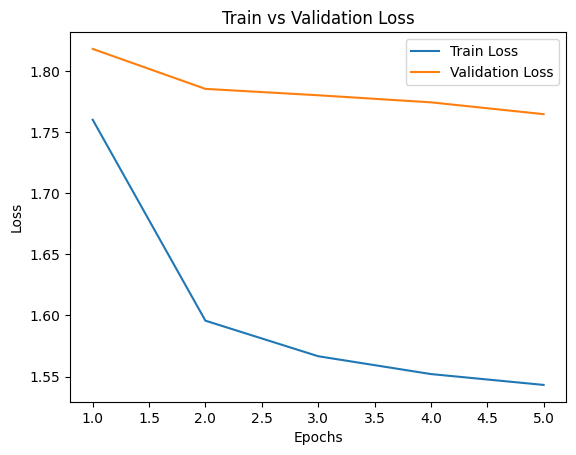

In [ ]:
# Hyperparameters
block_size = 30
batch_size = 16
lstm_layer = 3
embedding_size = 32
dropout = 0.0
learning_rate = 1e-3
epochs = 5
vocab_size = len(chars)

# Fixed seed
torch.manual_seed(42)

# Data
train_dataset = SequenceDataset(train_data, block_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = SequenceDataset(val_data, block_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

# Model
model = LSTM_LM(vocab_size = vocab_size,
                device = device,
                embedding_size = embedding_size,
                dropout = dropout,
                n_layer = lstm_layer)

# Training
model_last_state = train(model,
                        train_loader,
                        val_loader,
                        epochs = epochs,
                        batch_size = batch_size,
                        learning_rate = learning_rate,
                        device = device)

# Model Summary

In [ ]:
block_size = 30
batch_size = 16
lstm_layer = 3
embedding_size = 32
dropout = 0.0

In [ ]:
m = LSTM_LM(vocab_size = vocab_size,
                device = device,
                embedding_size = embedding_size,
                dropout = dropout,
                n_layer = lstm_layer)

In [ ]:
model_summary = summary(m,
                        input_size=(batch_size, block_size),
                        col_names=["input_size", "output_size", "num_params", "trainable"],
                        mode = 'eval',
                        col_width = 20,
                        depth = 3,
                        row_settings=["var_names"],
                        verbose = 2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LSTM_LM (LSTM_LM)                        [16, 30]             [16, 30, 65]         --                   True
├─Embedding (token_embedding)            [16, 30]             [16, 30, 32]         2,080                True
│    └─weight                                                                      └─2,080
├─LSTM (lstm)                            [16, 30, 32]         [16, 30, 32]         25,344               True
│    └─weight_ih_l0                                                                ├─4,096
│    └─weight_hh_l0                                                                ├─4,096
│    └─bias_ih_l0                                                                  ├─128
│    └─bias_hh_l0                                                                  ├─128
│    └─weight_ih_l1                                                                ├─4,096
│    └─weight_hh_

# Text Generation

In [ ]:
# Initialize the model with the same architecture as before
model4gen = LSTM_LM(vocab_size = vocab_size,
                    device = device,
                    embedding_size = 32,
                    dropout = 0.,
                    n_layer = 3).to(device)

# The evaluation mode is already considered in the "generate" method
# model.eval()

# Load the model weights, the number of layer of the loaded model must coincide with the initialized one
## Put the correct "checkpoint_path" !!
checkpoint_path = "/content/drive/My Drive/model_checkpoints/language_model_epoch_5_cpu.pt"
model4gen.load_state_dict(torch.load(checkpoint_path, map_location = torch.device(device)))

<All keys matched successfully>

In [ ]:
input_text = str(input('Write something related to the corpus: '))
encoded_text = encoder(input_text)
context = (context := torch.tensor(encoded_text, dtype=torch.long, device=device)).unsqueeze(0)

Write something related to the corpus: hi


In [ ]:
# Run for generation
print(decoder(model.generate(context, max_new_tokens = 750, temperature = 1.0)[0].tolist()))

hinwun justicus Tybadeever, lords, in love the storm,
You did thee,
My lordse dest you, thou
this touct, ererself, gone as a bodym welcold, what, so love, Peterlus sways are well I prison:--and full on
Fame defend offords, my prince; since readliest tooth, birds express of yourself.

Second Murderer:
Which, her orunger so,
Will wers by that 't glasfary of.

DUCHESS OF YORK:
And it flower of true,
And good live, that was indeed, sir, gible she sons;
Enk:
Mercted my name she;
what any with enstance of Link:
The hour to you. Tost speaking 's' in thet such no lorging to the east,
And thou weeping;
The chiet wome, excart; Cled receive these welcome, prove
Cold this,--N not less as revenge to behicious, he that seged o' the sueddrer'd the crackes
Y
